# Tutorial: Fermi GBM PHAII Data

Adapted from "GBM Science Data: Time History Spectra" in the Fermi GBM Data Tools documentation and "Fermi GBM PHAII Data" in the Fermi Gamma-ray Data Tools documentation.

The primary science data produced by the Fermi Gamma-ray Burst Monitor can be summarized as a time history of spectra, which is provided temporally pre-binned (CTIME and CSPEC) or temporally unbinned (TTE). These data types are produced as “snippets” for every single trigger and are also provided continuously. CTIME and CSPEC are provided in daily chunks, and TTE are provided in hourly chunks (since late 2012). One of the most common things that a user of GBM data wants to do is look at this data (plotting what we call a lightcurve) for one or more detectors over some energy range.

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to plot the lightcurves and count spectra of gamma-ray bursts using CSPEC and CTIME data from the Fermi Gamma-ray Burst Monitor.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 

The CTIME and CSPEC data are temporally pre-binned data, which have 8 and 128 energy channels respectively. These data files can be read by the `GbmPhaii` class from the GDT Fermi toolkit (or the aliased `Ctime` and `Cspec` classes). Let's begin by downloading a CTIME file. We will use event **120415958** as our example event for the rest of this tutorial.

In [2]:
# classes used to find and open data files
from gdt.core import data_path
from gdt.missions.fermi.gbm.finders import TriggerFtp

# we will be using the GbmPhaii data class in this example, but the Cspec and Ctime classes can also be used
from gdt.missions.fermi.gbm.phaii import GbmPhaii

# download a ctime file associated with the triggered event 120415958 and the "nb" detector
ctime_finder = TriggerFtp('120415958')
ctime_finder.get_ctime(download_dir=data_path.joinpath('120415958'),dets='nb')

# open and read the downloaded ctime file
ctime = GbmPhaii.open(data_path.joinpath('120415958/glg_ctime_nb_bn120415958_v00.pha'))

Output()

Since GBM uses the FITS format, the data files have multiple data extensions, each with metadata information in a header. There is also a primary header that contains metadata relevant to the overall file. You can access this metadata information like so:

In [3]:
ctime.headers.keys()

['PRIMARY', 'EBOUNDS', 'SPECTRUM', 'GTI']

In [4]:
ctime.headers['PRIMARY']

CREATOR = 'GBM_SCI_Reader.pl v1.19' / Software and version creating file        
FILETYPE= 'PHAII   '           / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_11  '           / Individual detector name                       
OBSERVER= 'Meegan  '           / GLAST Burst Monitor P.I.                       
ORIGIN  = 'GIOC    '           / Name of organization making file               
DATE    = '2012-04-16T02:15:21' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
DATE-OBS= '2012-04-15T22:45:25.975' / Date of start of observation              
DATE-END= '2012-04-15T23:17:06.175' / Date of end of observation                
TIMESYS = 'TT      '           / Time system used in time keywords              
TIMEUNIT= 's       '        

You can also easily access certain important properties of the data.

In [5]:
# the good time intervals for the data
print("GTI: {}".format(ctime.gti))

# the trigger time
print("Trigger time: {}".format(ctime.trigtime))

# the time range
print("Time Range: {}".format(ctime.time_range))

# the energy range
print("Energy Range: {}".format(ctime.energy_range))

# the number of energy channels
print('# of Energy Channels: {}'.format(ctime.num_chans))

GTI: <Gti: 1 intervals; range (-899.3424419760704, 1000.8578699827194)>
Trigger time: 356223561.133346
Time Range: (-899.3424419760704, 1000.8578699827194)
Energy Range: (4.323754, 2000.0)
# of Energy Channels: 8


We can retrieve the time history spectra data contained within the file, which is a `TimeEnergyBins` class.

In [6]:
ctime.data

<TimeEnergyBins: 14433 time bins;
 time range (-899.3424419760704, 1000.8578699827194);
 1 time segments;
 8 energy bins;
 energy range (4.323754, 2000.0);
 1 energy segments>

Through the `Phaii` base class, there are a lot of high level functions available to us. For example, if we only want to work with a short time segment of data in the file, we can take a slice of the data and return a new fully-functional data object with the time-sliced data.

In [7]:
# slice from approximately -10 to +10 seconds and display the sliced time range
time_sliced_ctime = ctime.slice_time((-10.0, 10.0))
time_sliced_ctime.time_range

(-10.240202009677887, 10.048128008842468)

You can also slice of the data in energy, like so:

In [8]:
# slice from approximately 50 keV to 300 keV and display the sliced energy range
energy_sliced_ctime = ctime.slice_energy((50.0, 300.0))
energy_sliced_ctime.energy_range

(49.60019, 538.1436)

As mentioned, this data is 2-dimensional, so what do we do if we want a lightcurve covering a particular energy range? You would integrate (sum) over energy, which you can easily do with the `to_lightcurve()` method:

In [9]:
# integrate over the full energy range
lightcurve = ctime.to_lightcurve()

# the lightcurve bin centroids and count rates
lightcurve.centroids, lightcurve.rates

(array([-899.21444198, -898.95853901, -898.70263603, ..., 1000.21786997,
        1000.47386995, 1000.72986996]),
 array([   0.    , 1186.1779, 1596.2815, ..., 1168.0736, 1136.9364,
        1160.156 ], dtype='>f4'))

In [10]:
# integrate over 50-500 keV
lightcurve = ctime.to_lightcurve(energy_range=(50.0, 500.0))

# the lightcurve bin centroids and count rates
lightcurve.centroids, lightcurve.rates

(array([-899.21444198, -898.95853901, -898.70263603, ..., 1000.21786997,
        1000.47386995, 1000.72986996]),
 array([  0.     , 223.88126, 439.27155, ..., 466.4455 , 380.28564,
        437.49994], dtype='>f4'))

Of course, once we have produced a lightcurve data object, often we want to plot it. For that, we use the `Lightcurve` plotting class from the GDT Core toolkit. 

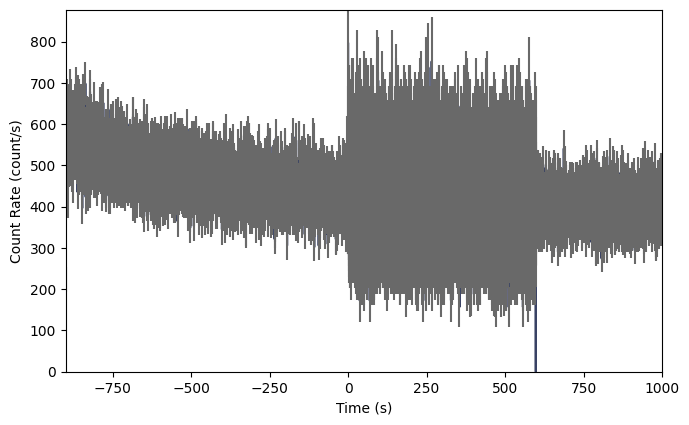

In [11]:
from gdt.core.plot.lightcurve import Lightcurve

# plot and show the lightcurve using the data integrated over 50-500 keV
lcplot = Lightcurve(data=lightcurve)
plt.show()

This plot may look odd without context. Since we are reading a trigger CTIME file, the file contains multiple time resolutions. Normally the CTIME data is accumulated in 256 ms duration bins, but starting at trigger time, the data switches to 64 ms duration bins for several hundred seconds, and then it goes back to 256 ms bins.

The native CTIME resolution may make it difficult to see the signal. We can make the signal easier to see if we bin the data up using the `rebin_by_time` function.

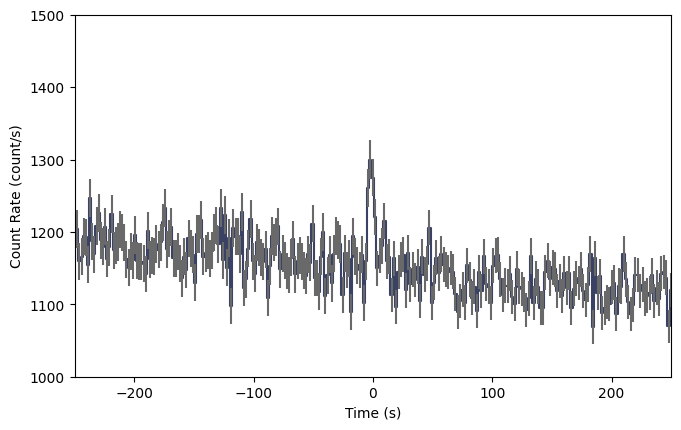

In [12]:
# the data binning module
from gdt.core.binning.binned import rebin_by_time

# rebin the data to 2048 ms resolution
rebinned_ctime = ctime.rebin_time(rebin_by_time, 2.048)

# and replot, zooming in
lcplot = Lightcurve(data=rebinned_ctime.to_lightcurve())
lcplot.xlim = (-250.0, 250.0)
lcplot.ylim = (1000.0, 1500.0)

After rebinning the data and zooming in a little, we can now easily see the GRB signal in the lightcurve.

You can just as easily create a count spectrum, integrating over time instead of energy, using the `to_spectrum()` method.

In [13]:
# integrate over the full time range
spectrum = ctime.to_spectrum()

# the energy channel centroids and differential count rates
spectrum.centroids, spectrum.rates

(array([   7.04047 ,   17.340723,   36.069298,   70.78455 ,  171.29333 ,
         395.36002 ,  732.5708  , 1412.2628  ], dtype=float32),
 array([ 61.2879  , 319.25937 , 230.99649 , 167.85733 , 206.852   ,
         64.629135,  48.869965,  74.911125], dtype=float32))

In [14]:
# integrate over the time range (-10.0, +10.0)
spectrum = ctime.to_spectrum(time_range=(-10.0, 10.0))

# the energy channel centroids and differential count rates
spectrum.centroids, spectrum.rates

(array([   7.04047 ,   17.340723,   36.069298,   70.78455 ,  171.29333 ,
         395.36002 ,  732.5708  , 1412.2628  ], dtype=float32),
 array([ 61.684734, 330.88147 , 253.36745 , 179.06876 , 205.1376  ,
         57.92528 ,  47.141582,  64.652725], dtype=float32))

The corresponding plot for the count spectrum can be made using the `Spectrum` class.

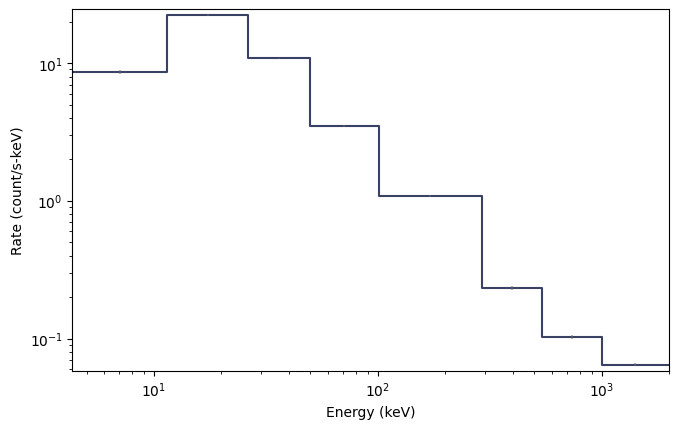

In [15]:
from gdt.core.plot.spectrum import Spectrum

# plot and show the count spectrum using the data integrated over -10 to +10 seconds
specplot = Spectrum(data=spectrum)
plt.show()

The count spectrum for CTIME data might not be quite as interesting as the lightcurve, since CTIME is only 8-channel data. The count spectra for CSPEC and TTE data are much prettier. 

It’s worth noting here that this spectrum is integrated over the full duration of the data, so perhaps you are interesting in a particular time range of data. You can make a single-spectrum PHA object like this:

In [16]:
# integrate over a single time selection
pha1 = ctime.to_pha(time_ranges=[(-10.0, 10.0)])

# integrate over multiple time selections
pha2 = ctime.to_pha(time_ranges=[(-10.0, 10.0), (20.0, 30.0)])

Let’s revisit our time-sliced CTIME object. Maybe we are doing some sort of analysis using the GBM continuous data and we don’t want to save the full day’s worth of data for our analysis. We can write our sliced CTIME object to a fully-qualified PHAII FITS file like so:

In [18]:
# write new gbm phaii fits file with time sliced phaii data
time_sliced_ctime.write('./', filename='my_first_custom_ctime.pha',overwrite=True)

Congratulations, you’ve completed the lesson on PHAII data!